In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('data.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
2,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000
3,1990-04-01,339.940002,347.299988,327.760010,330.799988,330.799988,2801220000
4,1990-05-01,330.799988,362.260010,330.799988,361.230011,361.230011,3596680000
...,...,...,...,...,...,...,...
408,2024-01-01,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,81737880000
409,2024-02-01,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000
410,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000
411,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000


In [278]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1990-01-01,329.079987
1,1990-02-01,331.890015
2,1990-03-01,339.940002
3,1990-04-01,330.799988
4,1990-05-01,361.230011
...,...,...
408,2024-01-01,4845.649902
409,2024-02-01,5096.270020
410,2024-03-01,5254.350098
411,2024-04-01,5035.689941


In [279]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [280]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 3
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3)
Date,,,,
1990-04-01,330.799988,339.940002,331.890015,329.079987
1990-05-01,361.230011,330.799988,339.940002,331.890015
1990-06-01,358.019989,361.230011,330.799988,339.940002
1990-07-01,356.149994,358.019989,361.230011,330.799988
1990-08-01,322.559998,356.149994,358.019989,361.230011
...,...,...,...,...
2024-01-01,4845.649902,4769.830078,4567.799805,4193.799805
2024-02-01,5096.270020,4845.649902,4769.830078,4567.799805
2024-03-01,5254.350098,5096.270020,4845.649902,4769.830078


In [281]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 330.79998779,  339.94000244,  331.89001465,  329.07998657],
       [ 361.23001099,  330.79998779,  339.94000244,  331.89001465],
       [ 358.01998901,  361.23001099,  330.79998779,  339.94000244],
       ...,
       [5254.35009766, 5096.27001953, 4845.64990234, 4769.83007812],
       [5035.68994141, 5254.35009766, 5096.27001953, 4845.64990234],
       [5214.08007812, 5035.68994141, 5254.35009766, 5096.27001953]])

In [282]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.98917249, -0.98547981, -0.9887321 , -0.98953315],
       [-0.9768784 , -0.98917249, -0.98547981, -0.98836042],
       [-0.97817529, -0.9768784 , -0.98917249, -0.98500084],
       ...,
       [ 1.        ,  0.93613378,  0.83488029,  0.86376396],
       [ 0.91165871,  1.        ,  0.93613378,  0.89540651],
       [ 0.98373044,  0.91165871,  1.        ,  1.        ]])

In [283]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((410, 3), (410,))

In [284]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98953315, -0.9887321 , -0.98547981],
       [-0.98836042, -0.98547981, -0.98917249],
       [-0.98500084, -0.98917249, -0.9768784 ],
       ...,
       [ 0.86376396,  0.83488029,  0.93613378],
       [ 0.89540651,  0.93613378,  1.        ],
       [ 1.        ,  1.        ,  0.91165871]])

In [285]:
split_index = int(len(X) * 0.95)

split_index

389

In [286]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((389, 3), (21, 3), (389,), (21,))

In [287]:

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((389, 3, 1), (21, 3, 1), (389, 1), (21, 1))

In [288]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([389, 3, 1]),
 torch.Size([21, 3, 1]),
 torch.Size([389, 1]),
 torch.Size([21, 1]))

In [289]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [290]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [291]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 3, 1]) torch.Size([16, 1])


In [292]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [293]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [294]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [297]:
lr = 0.01
epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for epoch in range(epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.179
***************************************************

Epoch: 2

Val Loss: 0.114
***************************************************

Epoch: 3

Val Loss: 0.099
***************************************************

Epoch: 4

Val Loss: 0.064
***************************************************

Epoch: 5

Val Loss: 0.077
***************************************************

Epoch: 6

Val Loss: 0.056
***************************************************

Epoch: 7

Val Loss: 0.050
***************************************************

Epoch: 8

Val Loss: 0.041
***************************************************

Epoch: 9

Val Loss: 0.035
***************************************************

Epoch: 10

Val Loss: 0.032
***************************************************



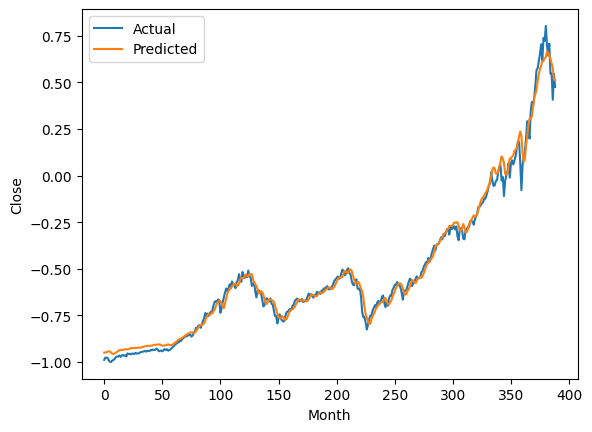

In [298]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()
import matplotlib.pyplot as plt
plt.plot(y_train, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Month')
plt.ylabel('Close')
plt.legend()
plt.show()

In [299]:
with torch.no_grad():
  y_pred = model(X_test.to(device)).to('cpu').numpy()
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
train_predictions = y_pred.flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
y_pred = dc(dummies[:, 0])
dummies = np.zeros((y_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
ny_test = dc(dummies[:, 0])
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(ny_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(ny_test, y_pred)}\nR2 Score: {r2_score(ny_test, y_pred)}')

The evaluations are as follows
Mean Squared Error: 122306.96007246964
Mean Absolute Error: 283.0593510730178
R2 Score: 0.4391783352499201


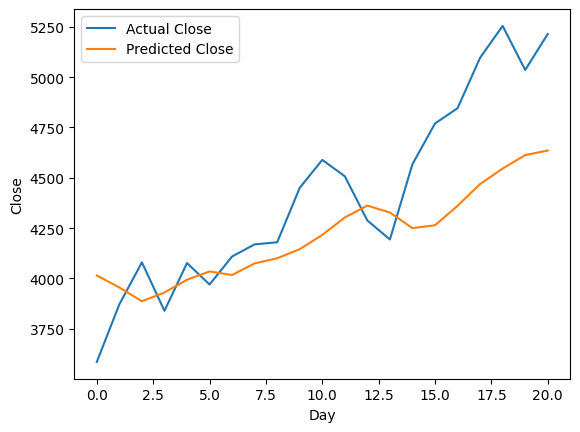

In [300]:
plt.plot(ny_test, label='Actual Close')
plt.plot(y_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [216]:
torch.save(model, 'lstm.pth')
from google.colab import files
files.download('lstm.pth')
import pickle
with open('mms.pkl', 'wb') as file:
  pickle.dump(scaler, file)
files.download('mms.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [224]:
to_save = pd.DataFrame({'Date':data['Date'].iloc[-y_pred.shape[0]:], 'Actual':ny_test, 'Predicted':y_pred})
to_save.to_csv('lstm.csv')
files.download('lstm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [221]:
data['Date'].iloc[split_index:].shape

(24,)

In [223]:
y_pred.shape

(21,)